In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('StudentsPerformance.csv')
print(df.head())

   gender race/ethnicity  ... reading score writing score
0  female        group B  ...            72            74
1  female        group C  ...            90            88
2  female        group B  ...            95            93
3    male        group A  ...            57            44
4    male        group C  ...            78            75

[5 rows x 8 columns]


In [ ]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [ ]:
df.isnull().sum()

,0
gender,0
race/ethnicity,0
parental level of education,0
lunch,0
test preparation course,0
math score,0
reading score,0
writing score,0


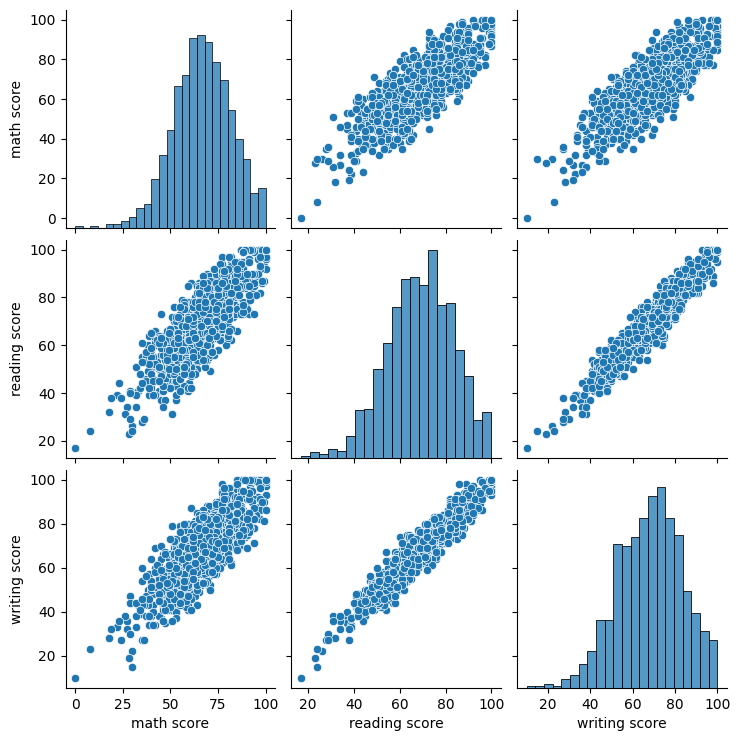

In [ ]:
sns.pairplot(df[['math score','reading score','writing score']])
plt.show()

In [ ]:
df['total score'] = df[['math score','reading score','writing score']].mean(axis=1)


In [ ]:
X = df.drop(columns=['math score','reading score','writing score','total score'])
y = df['total score']

In [ ]:
num_feats = X.select_dtypes(exclude='object').columns
cat_feats = X.select_dtypes(include='object').columns

In [ ]:
preproc = ColumnTransformer(
    [('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(drop='first'), cat_feats)]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
pipeline = Pipeline([
     ('prep', preproc),
     ('model', Lasso(max_iter=10000,random_state=42)),
  ])

In [ ]:
param_grid = {'model__alpha': np.logspace(-2, 1, 20)}   # 0.01 → 10
grid = GridSearchCV(pipeline, param_grid, cv=5,
                    scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index([], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course'],
      dtype='object'))])),
                                       ('model',
                                        Lasso(max_iter=10000,
                                              random_state=42))]),
             param_grid={'model__alpha': array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])},
             scoring='neg_root_mean_squared_error')

In [ ]:
print("Best alpha (shrinkage factor):", grid.best_params_['model__alpha'])


Best alpha (shrinkage factor): 0.029763514416313176


In [ ]:
y_pred = grid.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f} | R²: {r2:.3f}")


RMSE: 180.93 | R²: 0.156


In [ ]:
ohe = grid.best_estimator_.named_steps['prep'].named_transformers_['cat']
ohe_names = ohe.get_feature_names_out(cat_feats)
all_features = np.concatenate([ohe_names, num_feats])

coeffs = grid.best_estimator_.named_steps['model'].coef_
imp = pd.Series(coeffs, index=all_features).sort_values(key=abs, ascending=False)


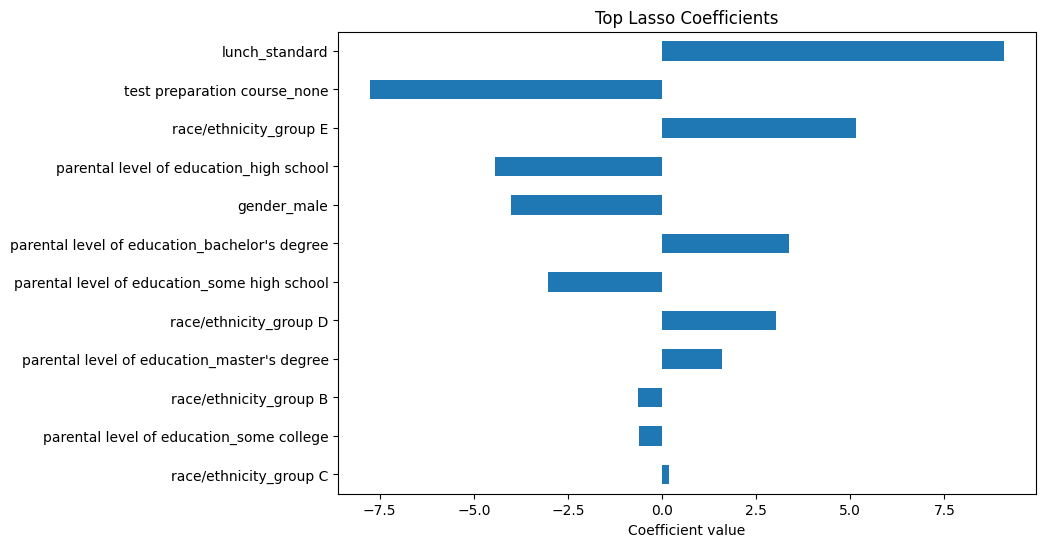

In [ ]:
plt.figure(figsize=(9,6))
imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top Lasso Coefficients')
plt.xlabel('Coefficient value')
plt.show()
